In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(SingleCellExperiment)
library(scater)
library(mclust)
library(kableExtra)
library(cowplot)
library(tidyverse)
library(reshape)
library(harmony)
library(SingleR)
library(topGO)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(ReactomePA)
library(seq2pathway)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(clusterProfiler)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 20),
    axis.title = element_text(size = 20),
    text = element_text(size = 20, colour = "black"),
    legend.text = element_text(size = 20),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: ‘DT’


The following object is masked from ‘package:SeuratObject’:

    JS


The following object is masked from ‘package:Seurat’:

    JS



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


here() starts at /home/vercanie/PRIMUS/data/48_lab/Jupyter/231003_DiabetesV02

Loading required package: SummarizedExperiment

Loading requir

Warning message:
“replacing previous import ‘WGCNA::cor’ by ‘stats::cor’ when loading ‘seq2pathway’”
scCustomize v1.1.1
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:reshape’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:IRanges’:

    sli

# All diabetes data - new and old

## CD8 new

In [41]:
paths  <- list.files("data/rawdata/", full.names = T)

In [42]:
paths

[1] "data/rawdata//exp08_init_with_Mixcr.rds"      
 [2] "data/rawdata//exp10_init_with_Mixcr.rds"      
 [3] "data/rawdata//exp11_W1_init_with_Mixcr.rds"   
 [4] "data/rawdata//exp11_W2_init_with_Mixcr.rds"   
 [5] "data/rawdata//exp16_CD4_A_init_with_Mixcr.rds"
 [6] "data/rawdata//exp16_CD4_B_init_with_Mixcr.rds"
 [7] "data/rawdata//exp16_CD8_A_init_with_Mixcr.rds"
 [8] "data/rawdata//exp16_CD8_B_init_with_Mixcr.rds"
 [9] "data/rawdata//exp18_1_init_with_Mixcr.rds"    
[10] "data/rawdata//exp18_2_init_with_Mixcr.rds"    
[11] "data/rawdata//exp18_3_init_with_Mixcr.rds"    
[12] "data/rawdata//exp18_4_init_with_Mixcr.rds"    
[13] "data/rawdata//exp19_1_init_with_Mixcr.rds"    
[14] "data/rawdata//exp19_2_init_with_Mixcr.rds"    
[15] "data/rawdata//exp19_3_init_with_Mixcr.rds"    
[16] "data/rawdata//exp19_4_init_with_Mixcr.rds"    
[17] "data/rawdata//exp20_1_init_with_Mixcr.rds"    
[18] "data/rawdata//exp20_2_init_with_Mixcr.rds"    
[19] "data/rawdata//exp20_3_init_with_Mixcr.rds"    
[20] "data/rawdata//exp20_4_init_with_Mixcr.rds"

In [43]:
seu_list  <- map(paths[c(1,2,3,7,8,9,11,13,15,17,19)], readRDS)

In [44]:
seu_list[[2]]$hashtags  %>% table

.
 H1 H10  H2  H3  H4  H5  H6  H7  H8  H9 
743 831 821 762 825 695 821 761 787 802 

In [45]:
exp10_cd8  <- subset(seu_list[[2]], hashtags == "H5")

In [46]:
seu_list[[2]] <- exp10_cd8

In [48]:
new_dia_cd8  <- scCustomize::Merge_Seurat_List(seu_list)

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [49]:
new_dia_cd8

An object of class Seurat 
15166 features across 111682 samples within 3 assays 
Active assay: RNA (15152 features, 0 variable features)
 2 other assays present: Antibodies, PTPRC

In [50]:
options(future.globals.maxSize = 10000 * 1024^2)
plan("sequential")

In [51]:
DefaultAssay(new_dia_cd8)  <- "RNA"
new_dia_cd8 <- NormalizeData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- ScaleData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- FindVariableFeatures(new_dia_cd8, nfeatures = 1000, verbose = FALSE)
new_dia_cd8 <- RunPCA(new_dia_cd8, npcs = 12, verbose = FALSE)
new_dia_cd8 <- RunUMAP(new_dia_cd8, reduction = "pca", dims = 1:12)

20:50:48 UMAP embedding parameters a = 0.9922 b = 1.112

20:50:48 Read 111682 rows and found 12 numeric columns

20:50:48 Using Annoy for neighbor search, n_neighbors = 30

20:50:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:51:04 Writing NN index file to temp file /tmp/RtmpFmKJ2Q/file3f6c7755e7e649

20:51:07 Searching Annoy index using 1 thread, search_k = 3000

20:52:10 Annoy recall = 100%

20:52:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:52:21 Initializing from normalized Laplacian + noise (using irlba)

20:52:39 Commencing optimization for 200 epochs, with 4732156 positive edges

20:54:00 Optimization finished



In [52]:
new_dia_cd8 <- FindNeighbors(new_dia_cd8, dims = 1:12)
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 111682
Number of edges: 2924932

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8590
Number of communities: 22
Elapsed time: 78 seconds


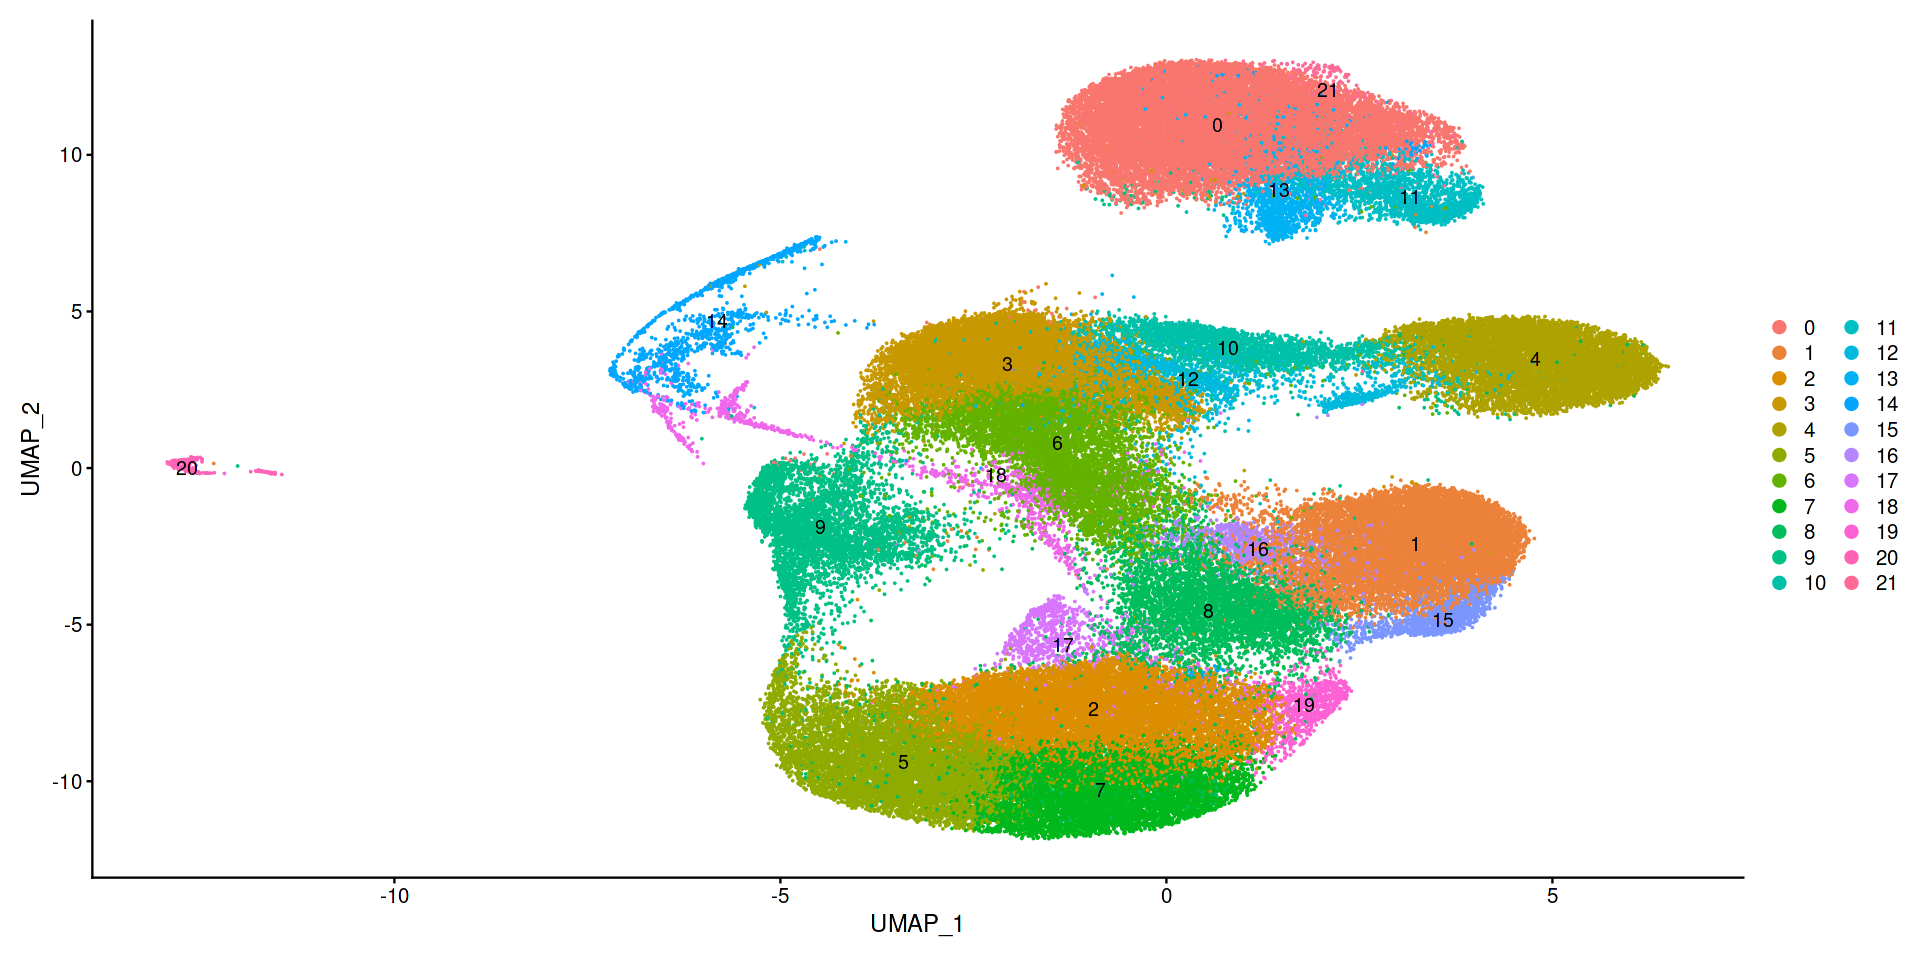

In [53]:
DimPlot(new_dia_cd8, label = T, raster = F)

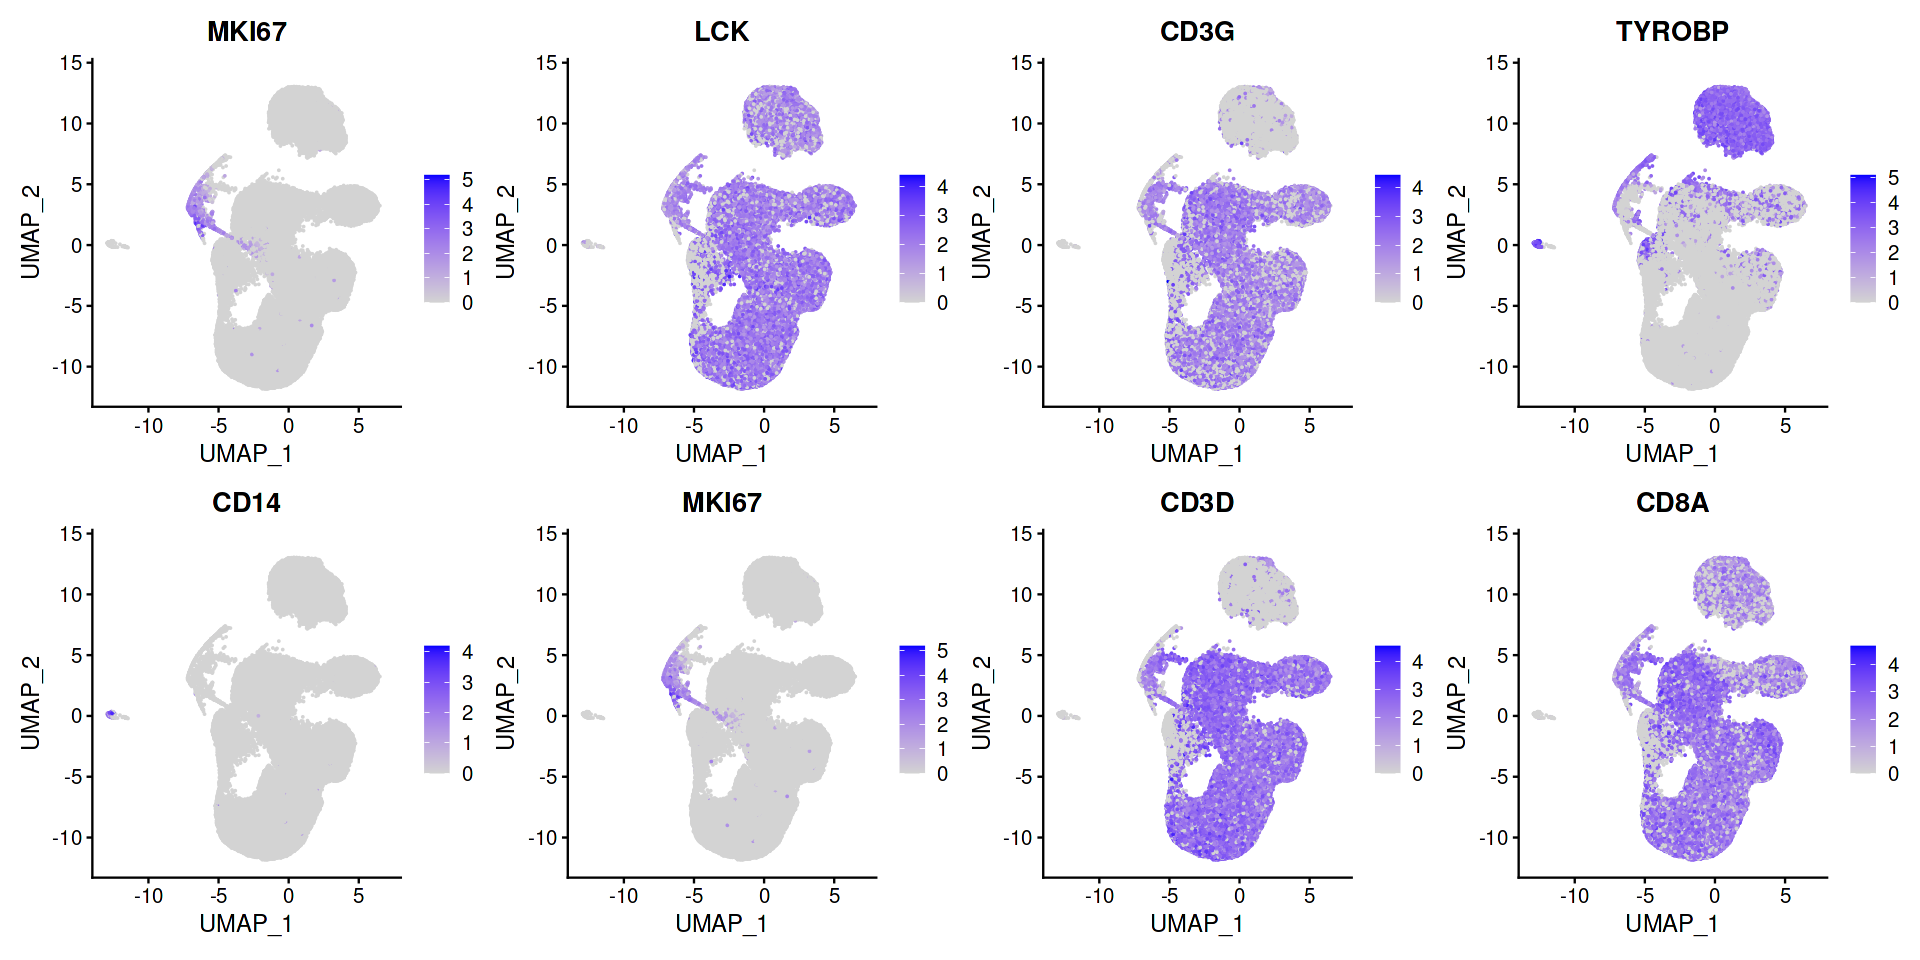

In [54]:
options(repr.plot.width = 16, repr.plot.height = 8)
FeaturePlot(new_dia_cd8, features = c("MKI67", "LCK", "CD3G", "TYROBP", "CD14", "MKI67", "CD3D", "CD8A"), ncol = 4, raster = F)

### Remove dead cells

In [57]:
cutoff_nFeature_RNA <- 500
cutoff_percent_mt <- 10
cluster_exclude  <- c(9,20)

Warning message in geom_hline(yintercept = cutoff_percent_mt, geom = "line", width = 0.5, :
“Ignoring unknown parameters: `geom` and `width`”
Warning message in geom_hline(yintercept = cutoff_nFeature_RNA, geom = "line", width = 0.5, :
“Ignoring unknown parameters: `geom` and `width`”


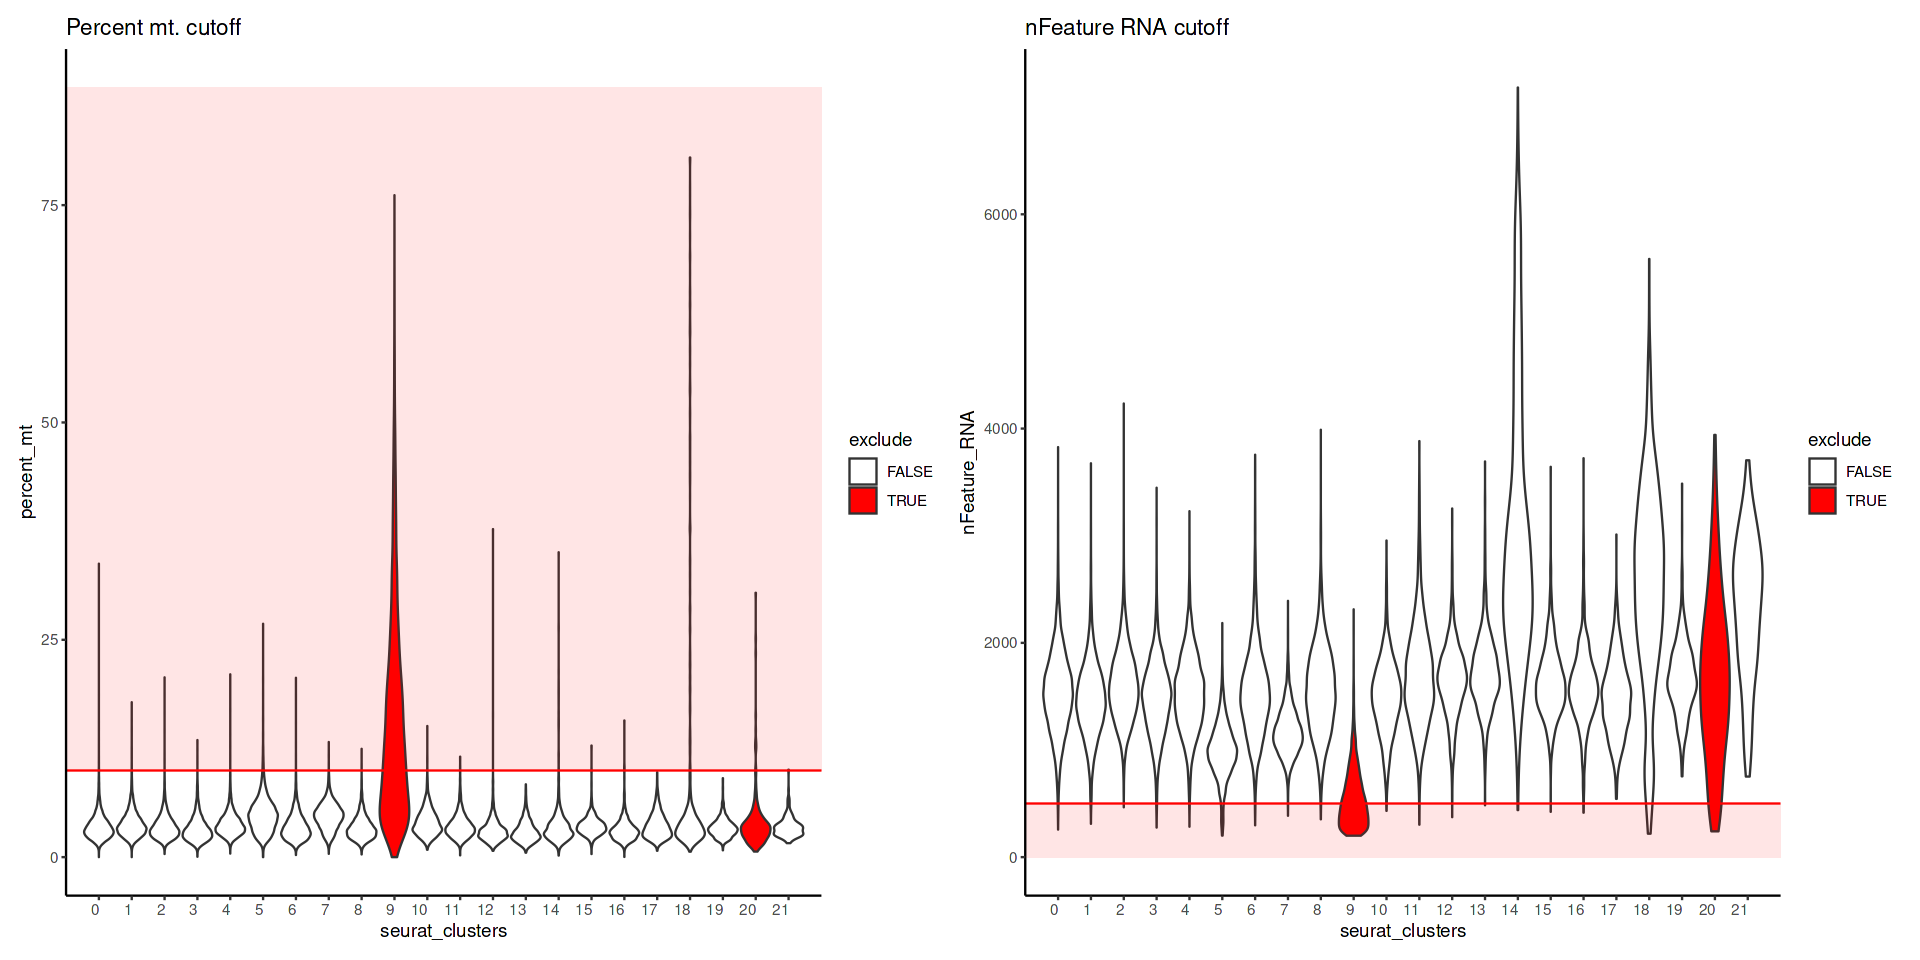

In [58]:
p1 <- ggplot(data.frame(nCount_RNA = new_dia_cd8$nCount_RNA,
                  nFeature_RNA = new_dia_cd8$nFeature_RNA,
                  percent_mt = new_dia_cd8$percent.mt,
                  seurat_clusters = new_dia_cd8$seurat_clusters,
                  exclude = ifelse(new_dia_cd8$seurat_clusters %in% cluster_exclude, TRUE, FALSE)), 
       aes(x = seurat_clusters, y = percent_mt)) +
  geom_violin(scale = "width", aes(fill = exclude)) + 
  geom_hline(yintercept = cutoff_percent_mt,
               geom = "line", 
               width = 0.5,
               colour = "red") + 
  ggtitle("Percent mt. cutoff") + 
  theme_classic() +
  scale_fill_manual(values = c("white","red")) +
  theme(panel.background = element_blank(), 
        axis.text.x = element_text(angle = 0, hjust = 1)) +
  annotate(geom = "rect", xmin = min(as.numeric(new_dia_cd8$seurat_clusters))-1, 
           xmax = max(as.numeric(new_dia_cd8$seurat_clusters))+1, 
           ymin=cutoff_percent_mt,ymax=1.1*(max(new_dia_cd8$percent.mt)), fill = "red", alpha = 0.1)

p2 <- ggplot(data.frame(nCount_RNA = new_dia_cd8$nCount_RNA,
                  nFeature_RNA = new_dia_cd8$nFeature_RNA,
                  percent_mt = new_dia_cd8$percent.mt,
                  seurat_clusters = new_dia_cd8$seurat_clusters,
                        exclude = ifelse(new_dia_cd8$seurat_clusters %in% cluster_exclude, TRUE, FALSE)), 
       aes(x = seurat_clusters, y = nFeature_RNA)) +
  geom_violin(scale = "width", aes(fill = exclude)) + 
  geom_hline(yintercept = cutoff_nFeature_RNA,
               geom = "line", 
               width = 0.5,
               colour = "red") + 
  ggtitle("nFeature RNA cutoff") + 
  theme_classic() +
  scale_fill_manual(values = c("white","red")) +
  theme(panel.background = element_blank(), 
        axis.text.x = element_text(angle = 0, hjust = 1)) +
  annotate(geom = "rect", xmin = min(as.numeric(new_dia_cd8$seurat_clusters))-1, 
           xmax = max(as.numeric(new_dia_cd8$seurat_clusters))+1, 
           ymin=0, ymax=cutoff_nFeature_RNA, fill = "red", alpha = 0.1)



p1 + p2

In [59]:
new_dia_cd8  <- subset(new_dia_cd8, 
                      percent.mt < cutoff_percent_mt &
                      nFeature_RNA > cutoff_nFeature_RNA & 
                       seurat_clusters %in% c(0:8,10:19,21))

In [60]:
new_dia_cd8 <- NormalizeData(new_dia_cd8, verbose = FALSE)

new_dia_cd8 <- ScaleData(new_dia_cd8, verbose = FALSE)
new_dia_cd8 <- FindVariableFeatures(new_dia_cd8, nfeatures = 800, verbose = FALSE)
new_dia_cd8 <- RunPCA(new_dia_cd8, npcs = 12, verbose = FALSE)
new_dia_cd8 <- RunUMAP(new_dia_cd8, reduction = "pca", dims = 1:12)

new_dia_cd8 <- FindNeighbors(new_dia_cd8, dims = 1:12)
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 1)

21:12:18 UMAP embedding parameters a = 0.9922 b = 1.112

21:12:18 Read 105591 rows and found 12 numeric columns

21:12:18 Using Annoy for neighbor search, n_neighbors = 30

21:12:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:12:33 Writing NN index file to temp file /tmp/RtmpFmKJ2Q/file3f6c7769074798

21:12:33 Searching Annoy index using 1 thread, search_k = 3000

21:13:33 Annoy recall = 100%

21:13:37 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:13:44 Initializing from normalized Laplacian + noise (using irlba)

21:13:58 Commencing optimization for 200 epochs, with 4452750 positive edges

21:15:14 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 105591
Number of edges: 2708726

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8516
Number of communities: 22
Elapsed time: 65 seconds


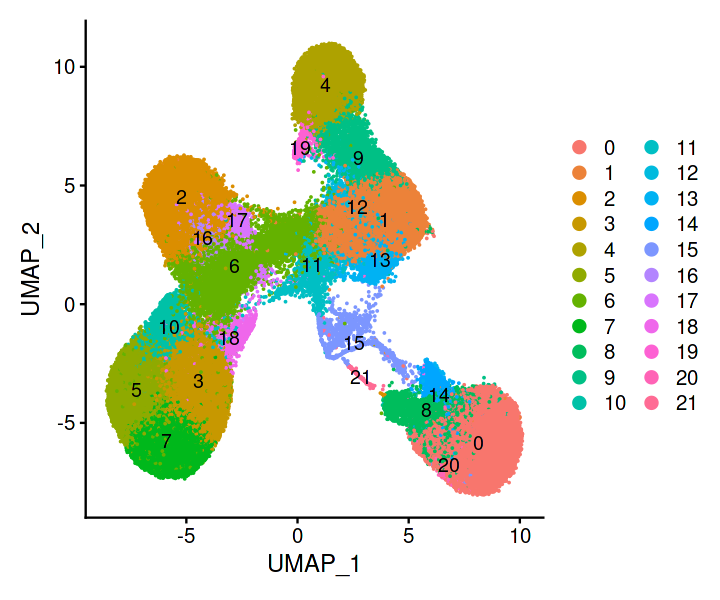

In [61]:
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(new_dia_cd8, label = T, raster = F)

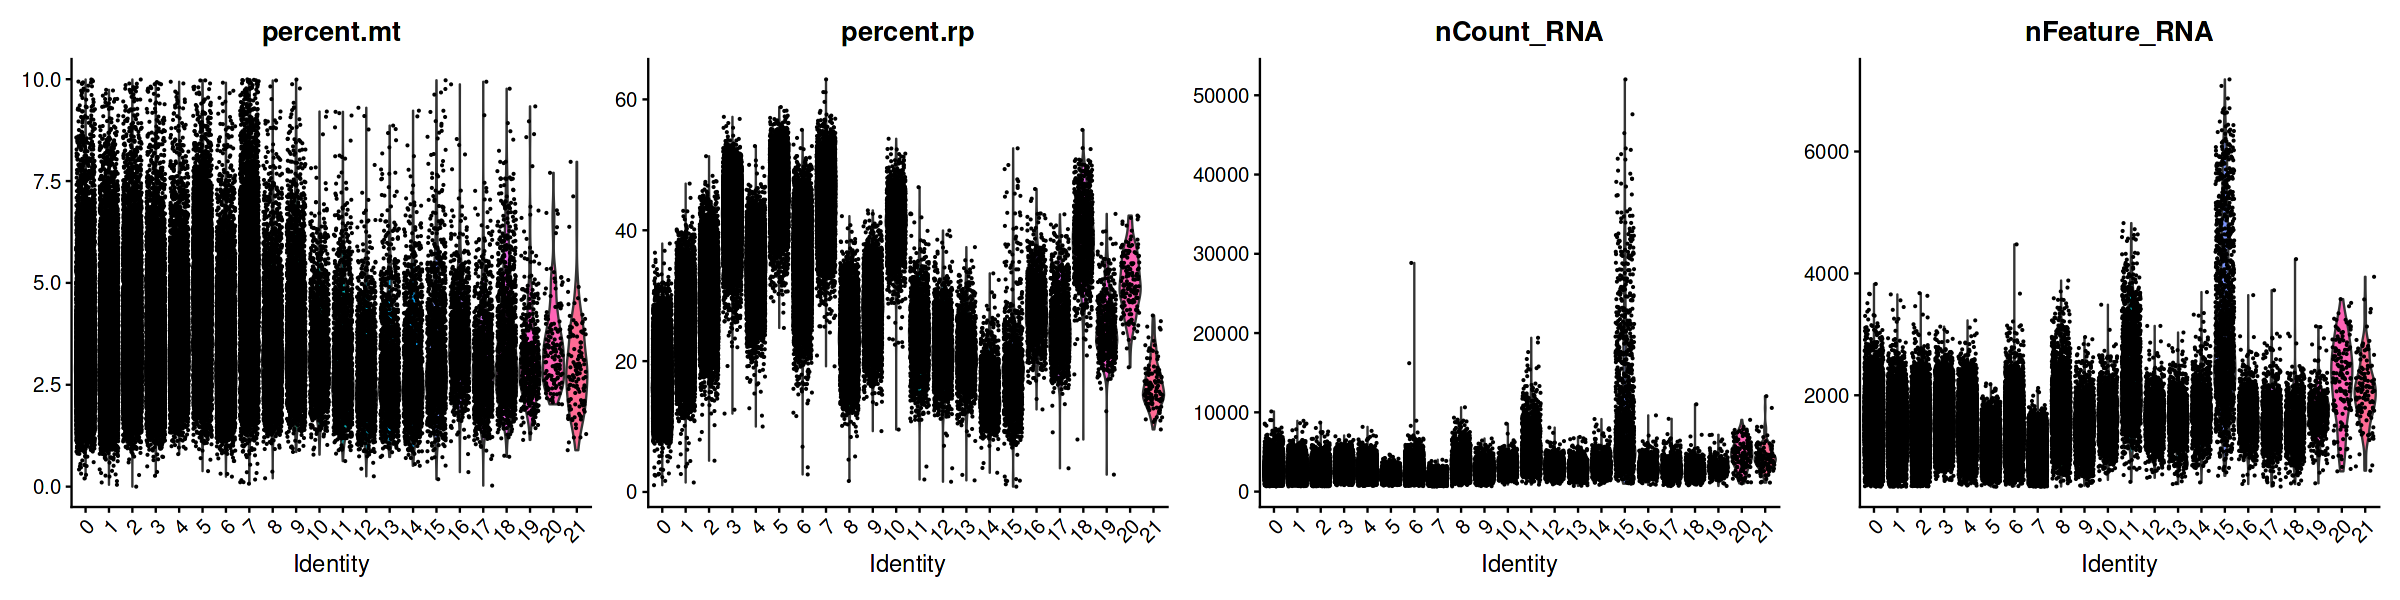

In [62]:
options(repr.plot.width = 20)
VlnPlot(new_dia_cd8, features = c("percent.mt", "percent.rp", "nCount_RNA", "nFeature_RNA"), ncol = 4, raster = F)

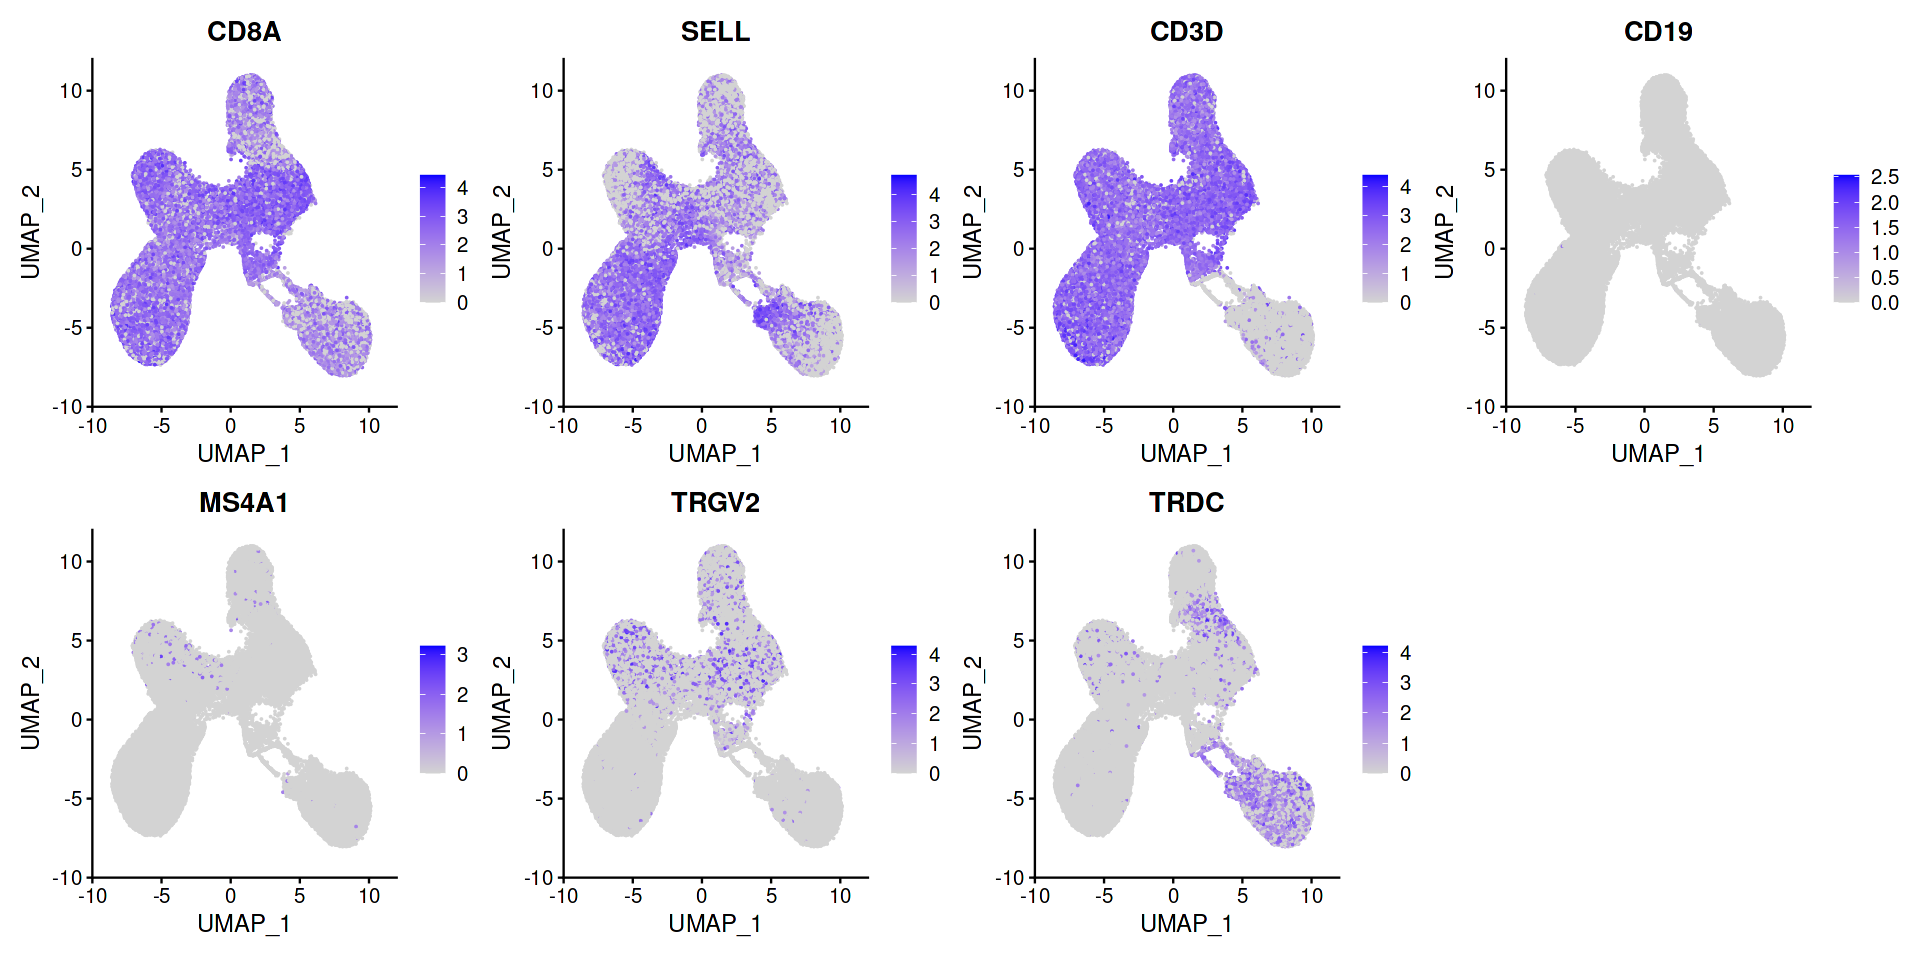

In [63]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd8, features = c("CD8A", "SELL", "CD3D", "CD19", "MS4A1", "TRGV2", "TRDC"), ncol = 4, raster = F)

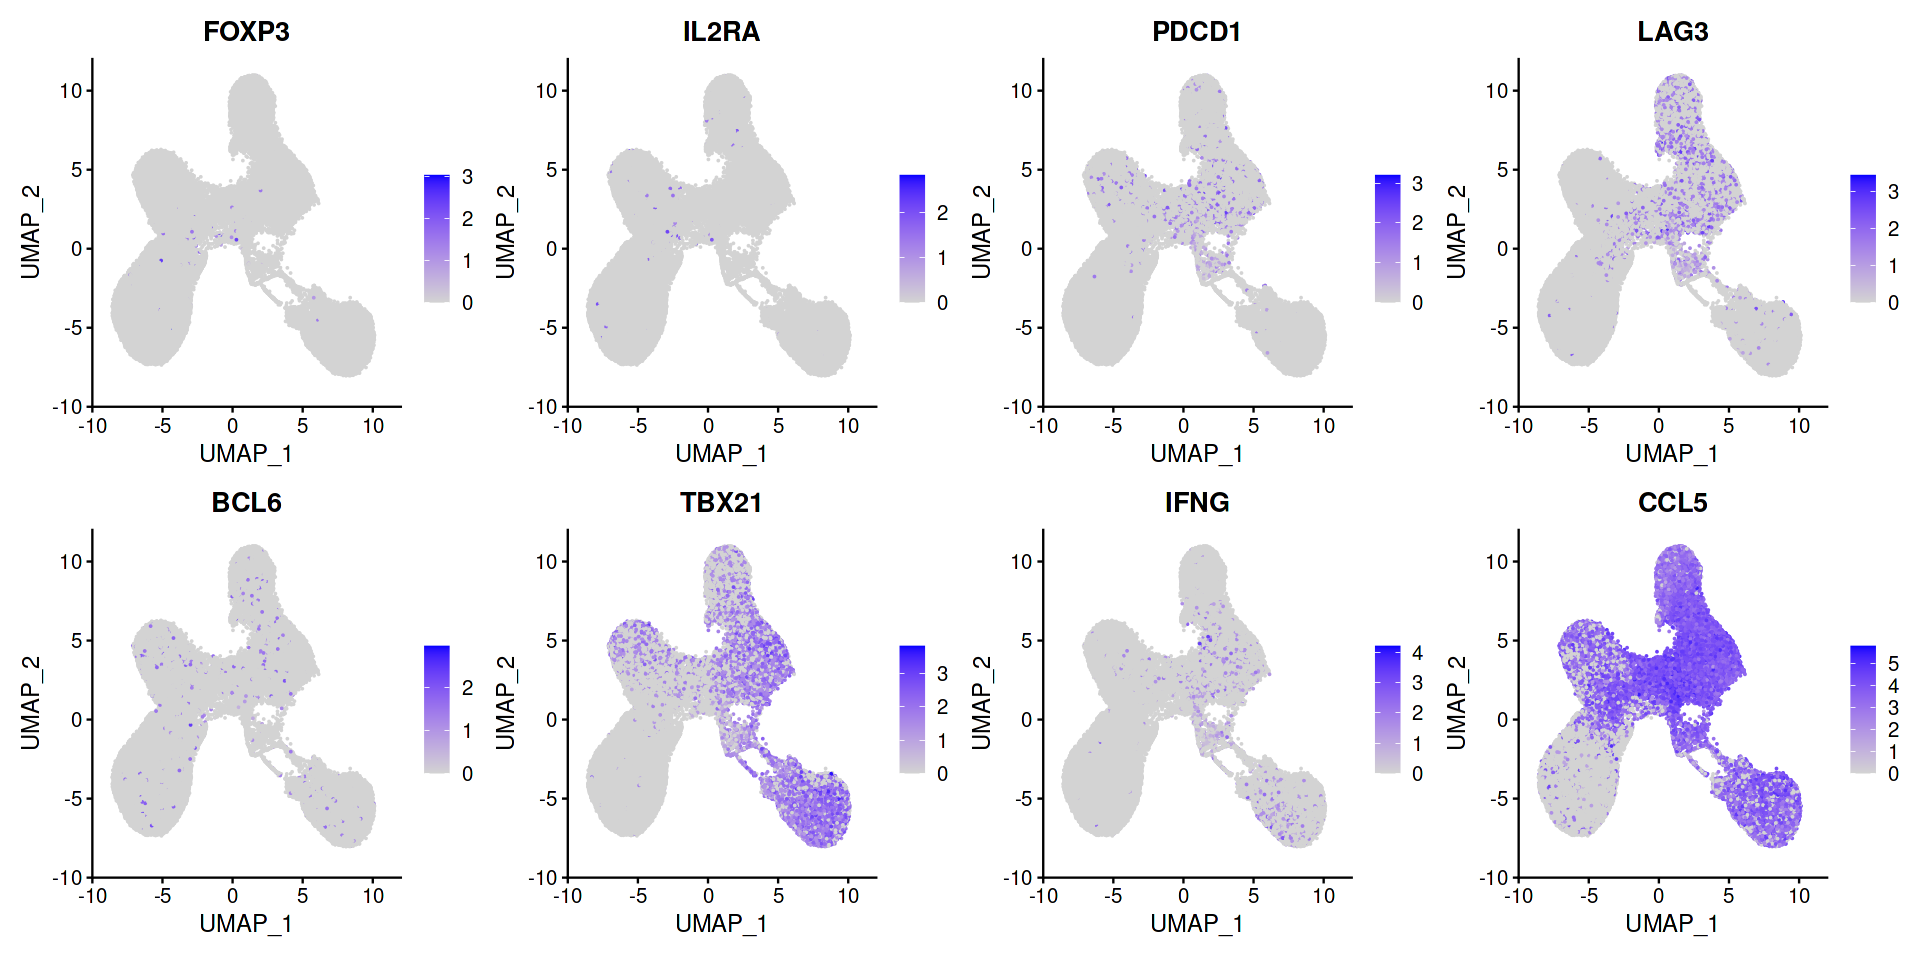

In [64]:
options(repr.plot.width = 16, repr.plot.height = 8)

FeaturePlot(new_dia_cd8, features = c("FOXP3", "IL2RA", "PDCD1", "LAG3", "BCL6", "TBX21", "IFNG", "CCL5"), ncol = 4, raster = F)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 105591
Number of edges: 2708726

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8890
Number of communities: 15
Elapsed time: 67 seconds


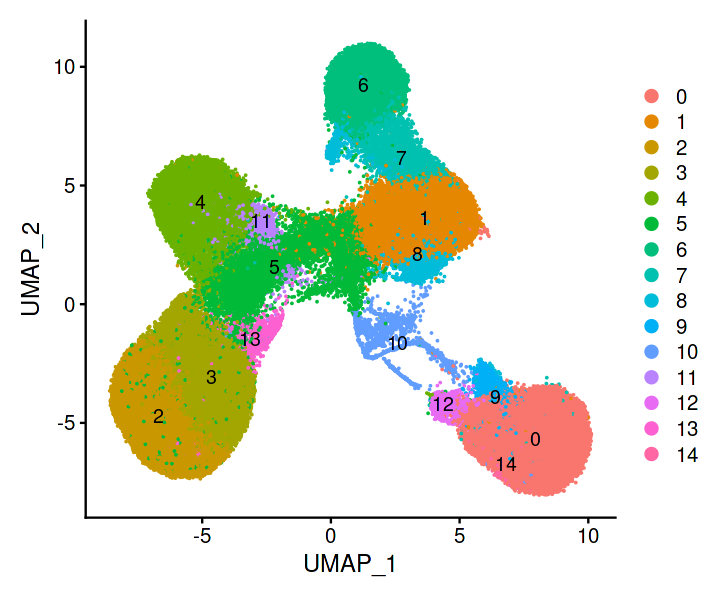

In [65]:
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 0.6)

options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(new_dia_cd8, label = T, raster = F)

### PCA on samples

In [66]:
new_dia_cd8@meta.data  %>% colnames

[1] "orig.ident"          "nCount_RNA"          "nFeature_RNA"       
 [4] "percent.mt"          "percent.rp"          "nCount_Antibodies"  
 [7] "nFeature_Antibodies" "hashtags"            "Experiment_ID"      
[10] "Date_prepared"       "Prepared_by"         "Sample_ID"          
[13] "Well"                "Hashtag"             "Hashtag_sequence"   
[16] "Hashtag_cat_n"       "Hashtag_dilution"    "Project.code"       
[19] "Well_CT_ID"          "Condition"           "Species"            
[22] "Age"                 "Age_group"           "Sex"                
[25] "Library_code"        "Patient_ID"          "is_cell"            
[28] "chain"               "contig_id"           "high_confidence"    
[31] "productive"          "length"              "reads"              
[34] "umis"                "vdj_source"          "count_TRA"          
[37] "count_TRB"           "count_Multi"         "cdr3_A1"            
[40] "cdr3_A1_nt"          "cdr3_A2"             "cdr3_A2_nt"         
[43] "cdr3_B"              "cdr3_B_nt"           "cdr3_Multi"         
[46] "cdr3_Multi_nt"       "v_gene_A1"           "j_gene_A1"          
[49] "v_gene_A2"           "j_gene_A2"           "v_gene_B"           
[52] "d_gene_B"            "j_gene_B"            "v_gene_Multi"       
[55] "d_gene_Multi"        "j_gene_Multi"        "clonotypes"         
[58] "has.VDJ"             "has.complete.VDJ"    "nCount_PTPRC"       
[61] "nFeature_PTPRC"      "RNA_snn_res.0.5"     "seurat_clusters"    
[64] "clonotype.repeated"  "RNA_snn_res.0.8"     "RNA_snn_res.1"      
[67] "RNA_snn_res.0.6"

In [67]:
new_dia_cd8$Condition  %>% table

.
   Ctrl T0    Ctrl T1     Dia T0     Dia T1 Pre-Dia T0 
     20170       4457      45689      31645       3630 

In [68]:
new_dia_cd8@meta.data  <- new_dia_cd8@meta.data  %>% separate(Condition, into = c("Disease", "Time"), remove = F, sep = " ")

In [69]:
new_dia_cd8$Sample_char  <- paste(new_dia_cd8$Patient_ID, 
                                  new_dia_cd8$Disease,
                                  new_dia_cd8$Time,
                                  new_dia_cd8$Age_group,
                                  new_dia_cd8$Sex,
                                  new_dia_cd8$Experiment_ID)

In [70]:
cd8_samples  <- AverageExpression(new_dia_cd8, group.by = "Sample_char", return.seurat = T)

Centering and scaling data matrix



In [71]:
cd8_samples  <- FindVariableFeatures(cd8_samples)

In [72]:
cd8_samples  <- RunPCA(cd8_samples)

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  ABHD17A, TGFB1, CAPNS1, PIP4K2A, AKT1, PREX1, KIAA2013, CD81, GNB1, GNAI2 
	   MAPK1, TRAPPC10, MAP2K2, ARL8A, FMNL1, EFHD2, STK39, ZNRF2, UTRN, TAF10 
	   ARHGAP26, PTP4A2, IQGAP1, GSK3A, CCDC92, CLPTM1L, QKI, RUNX3, BTBD6, BCL7C 
Negative:  RGS10, EIF3E, BTF3, NPM1, ST13, LSM5, ALKBH7, EIF3H, ANP32B, UQCRB 
	   PCBP2, OCIAD2, EEF1A1, C1QBP, SARAF, FKBP1A, PEBP1, LDLRAP1, IMPDH2, CCNI 
	   APEX1, LRRN3, ATP6V0E2, PLEKHB1, IFNGR2, NDFIP1, EIF2D, PRKAR1B, CLNS1A, TIMM9 
PC_ 2 
Positive:  SNRPD3, AC010422.8, CSNK2B, RNASEK, KLRK1, AC091959.1, DYNLRB1, STXBP2, NAA10, UBE2V1 
	   AC005833.1, MATR3.1, IL2RG, SARNP, AC129492.3, PTPRCAP, RAB5C, TRAPPC5, DHPS, AL358472.6 
	   ANKHD1, SLC35A1, AL365205.1, NOL12, ARL6IP1, CHMP4A, FKBP2, EEF1E1, VPS33A, PPAN-P2RY11 
Negative:  AMMECR1L, WASH6P, MTRNR2L12, R3HDM2, USF2, AC007

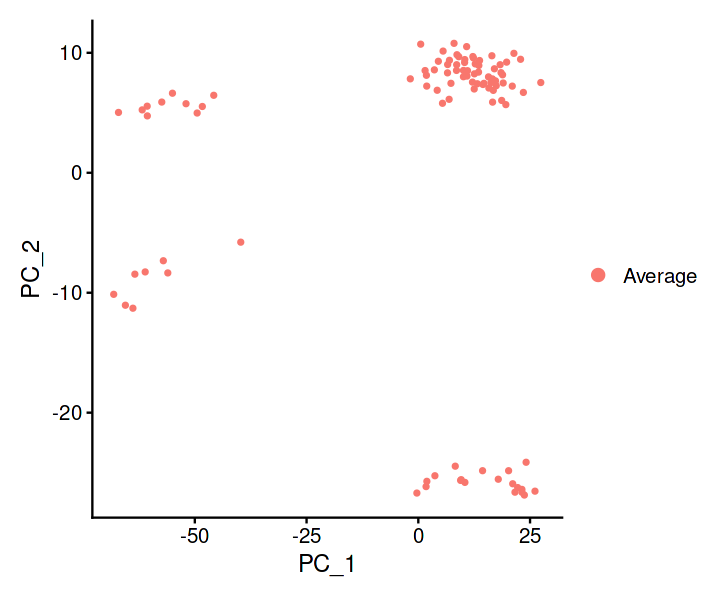

In [73]:
DimPlot(cd8_samples)

In [74]:
cd8_samples$Sample_char  <- colnames(cd8_samples)

In [75]:
cd8_samples$Sample_char  %>% table

.
    101 Dia T0 1 M Exp18     101 Dia T1 1 M Exp18     102 Dia T0 1 M Exp18 
                       1                        1                        1 
    102 Dia T1 1 M Exp18     103 Dia T0 2 M Exp18     103 Dia T1 2 M Exp18 
                       1                        1                        1 
    104 Dia T0 3 M Exp08     104 Dia T0 3 M Exp18     104 Dia T1 3 M Exp18 
                       1                        1                        1 
    105 Dia T0 1 M Exp08     105 Dia T0 1 M Exp18     105 Dia T1 1 M Exp18 
                       1                        1                        1 
    106 Dia T0 1 F Exp08     106 Dia T0 1 F Exp18     106 Dia T1 1 F Exp18 
                       1                        1                        1 
    107 Dia T0 1 M Exp11     107 Dia T0 1 M Exp18     107 Dia T1 1 M Exp18 
                       1                        1                        1 
    108 Dia T0 2 F Exp08     108 Dia T0 2 F Exp18     108 Dia T1 2 F Exp18 
          

In [76]:
cd8_samples@meta.data  <- cd8_samples@meta.data  %>% separate(Sample_char, 
                                                              into = c("Patient_ID",
                                                                      "Disease",
                                                                      "Time",
                                                                      "Age_group",
                                                                      "Sex",
                                                                      "Exp"), 
                                                             sep = " ",
                                                             remove = F)

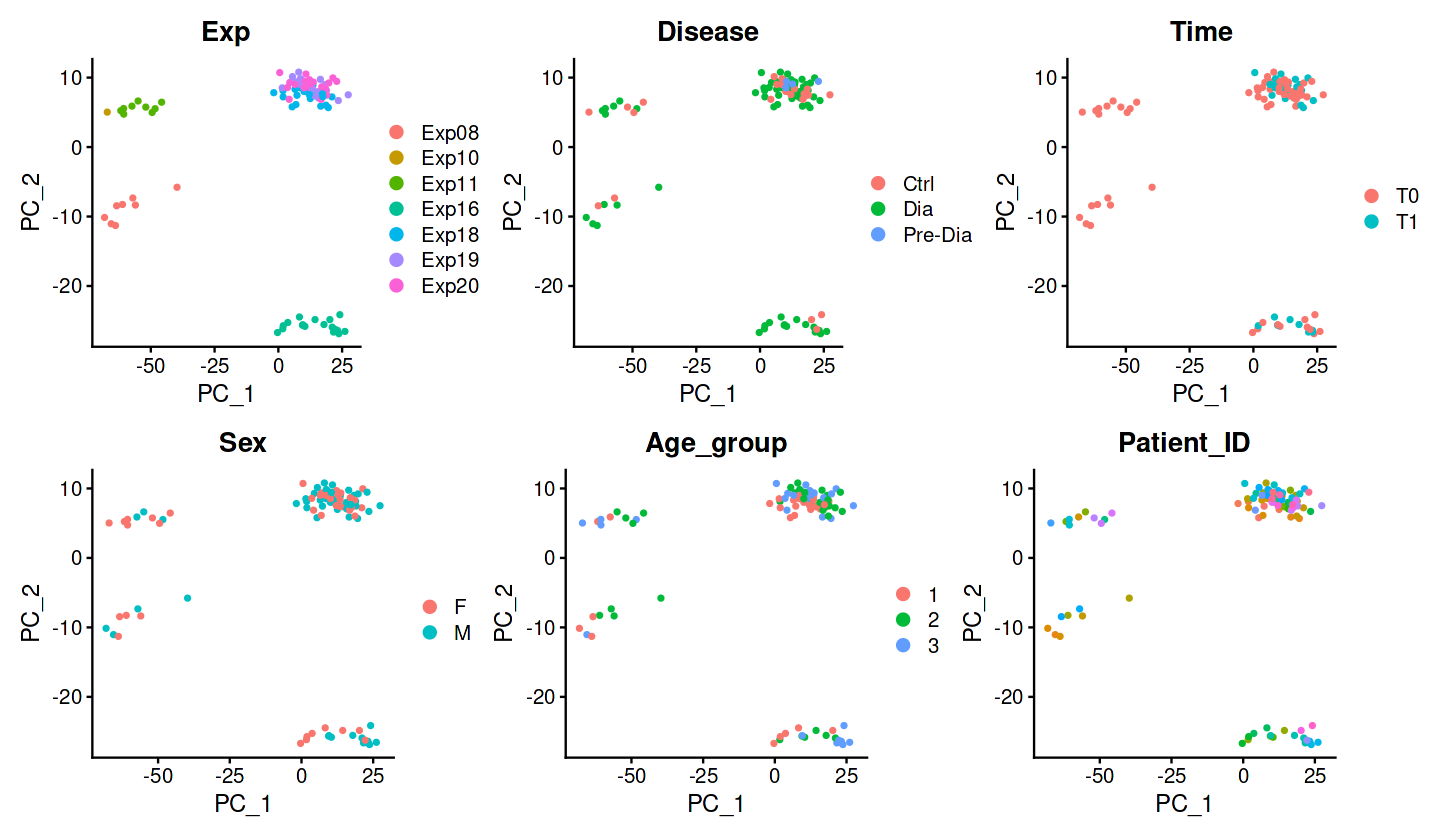

In [77]:
options(repr.plot.width = 12, repr.plot.height = 7)
(DimPlot(cd8_samples, group.by = "Exp") + DimPlot(cd8_samples, group.by = "Disease") + DimPlot(cd8_samples, group.by = "Time")) / (DimPlot(cd8_samples, group.by = "Sex") + DimPlot(cd8_samples, group.by = "Age_group") + (DimPlot(cd8_samples, group.by = "Patient_ID") + NoLegend()))

## STACAS Integration over Experiment

In [78]:
new_dia_experiment  <- SplitObject(new_dia_cd8, split.by = "Experiment_ID")

In [79]:
new_dia_experiment

$Exp08
An object of class Seurat 
15166 features across 7046 samples within 3 assays 
Active assay: RNA (15152 features, 1000 variable features)
 2 other assays present: Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp10
An object of class Seurat 
15166 features across 650 samples within 3 assays 
Active assay: RNA (15152 features, 1000 variable features)
 2 other assays present: Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp11
An object of class Seurat 
15166 features across 9615 samples within 3 assays 
Active assay: RNA (15152 features, 1000 variable features)
 2 other assays present: Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp16
An object of class Seurat 
15166 features across 15299 samples within 3 assays 
Active assay: RNA (15152 features, 1000 variable features)
 2 other assays present: Antibodies, PTPRC
 2 dimensional reductions calculated: pca, umap

$Exp18
An object of class Seurat 
15166 features acr

In [80]:
# normalize and identify variable features for each dataset independently
merged.list <- lapply(X = new_dia_experiment, FUN = function(x) {
    DefaultAssay(x)  <- "RNA"
    x$barcode  <- colnames(x)
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

library(STACAS)

new_dia_experiment <- Run.STACAS(merged.list, dims = 1:12)
new_dia_experiment <- RunUMAP(new_dia_experiment, dims = 1:12) 

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.0 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”
Preparing PCA embeddings for objects...

Building integration tree with base dataset: 6

Merging dataset 4 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 7 into 6 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 5 into 6 4 7

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 into 3

Extracting anchors for merged samples

Finding 

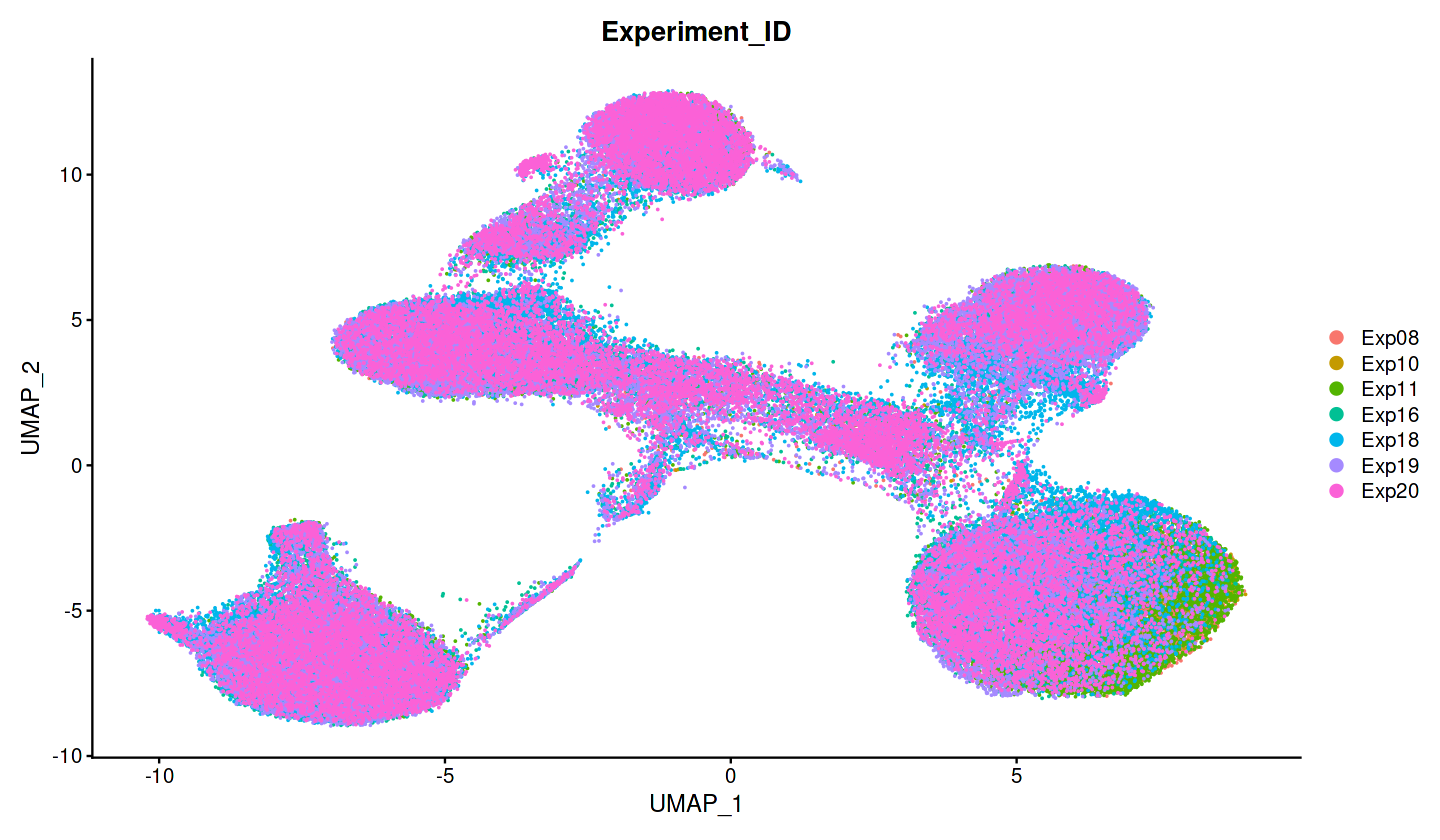

In [81]:
# Visualize
DimPlot(new_dia_experiment, group.by = c("Experiment_ID"), raster=F)

### PCA on samples

In [82]:
cd8_samples2  <- AverageExpression(new_dia_experiment, group.by = "Sample_char", return.seurat = T)

Centering and scaling data matrix



In [83]:
cd8_samples2  <- FindVariableFeatures(cd8_samples2)

In [84]:
cd8_samples2  <- RunPCA(cd8_samples2)

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  MYO1F, PYHIN1, ACTN4, IQGAP1, ADAM8, STOM, IQGAP2, KLRD1, TBX21, SLAMF7 
	   CST7, SPN, RAP1GAP2, GK5, NKG7, MSN, NFATC2, FLNA, UTRN, SYNE2 
	   TLN1, TGFBR3, SRGN, APMAP, PIK3AP1, ATP2B4, C1orf21, MCTP2, FGR, S1PR5 
Negative:  LDHB, ACTN1, RGS10, TRABD2A, ARMH1, NELL2, MAL, LDLRAP1, A1BG, BZW2 
	   DNPH1, NPM1, AIF1, CD248, NT5E, LRRN3, IMPDH2, NAP1L1, LEF1, OXNAD1 
	   AHCY, IL6ST, BEX3, HSPB1, SERINC5, TCF7, RCAN3, FOXP1, IL6R, NOG 
PC_ 2 
Positive:  SOCS3, MAP3K1, RTKN2, RELB, ANK1, PPP2R5C, ZNF683, ATP2B1, TIAM1, ARID5B 
	   TRGV10, PLCH2, C4orf48, EZR, HOOK2, CD82, NPDC1, GPR15, ANXA5, IGHM 
	   DUSP2, MYADM, IKZF2, CLDND1, FXYD1, TNFAIP3, LYAR, LMNA, ELOVL5, PI16 
Negative:  CYBA, PCSK5, C1orf162, TRBC1, WDR1, ARPC5, CXCR2, CATSPER1, ARPC2, ABI3 
	   RASSF4, CCDC28B, SIGLEC7, AKR1C3, NMUR1, FCER1G, SERPINB1

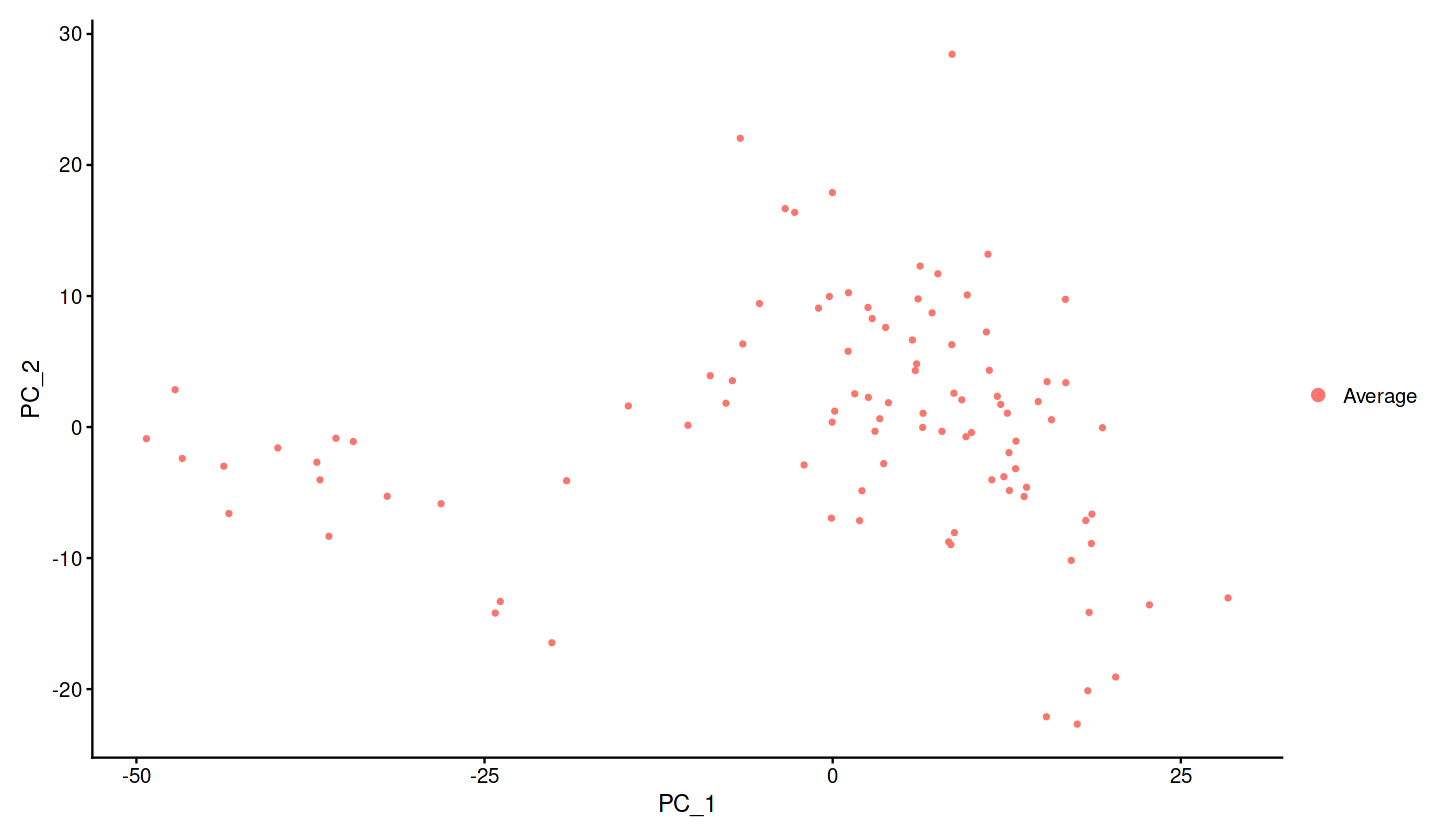

In [85]:
DimPlot(cd8_samples2)

In [86]:
cd8_samples2$Sample_char  <- colnames(cd8_samples2)

In [87]:
cd8_samples2@meta.data  <- cd8_samples2@meta.data  %>% separate(Sample_char, 
                                                              into = c("Patient_ID",
                                                                      "Disease",
                                                                      "Time",
                                                                      "Age_group",
                                                                      "Sex",
                                                                      "Exp"), 
                                                             sep = " ",
                                                             remove = F)

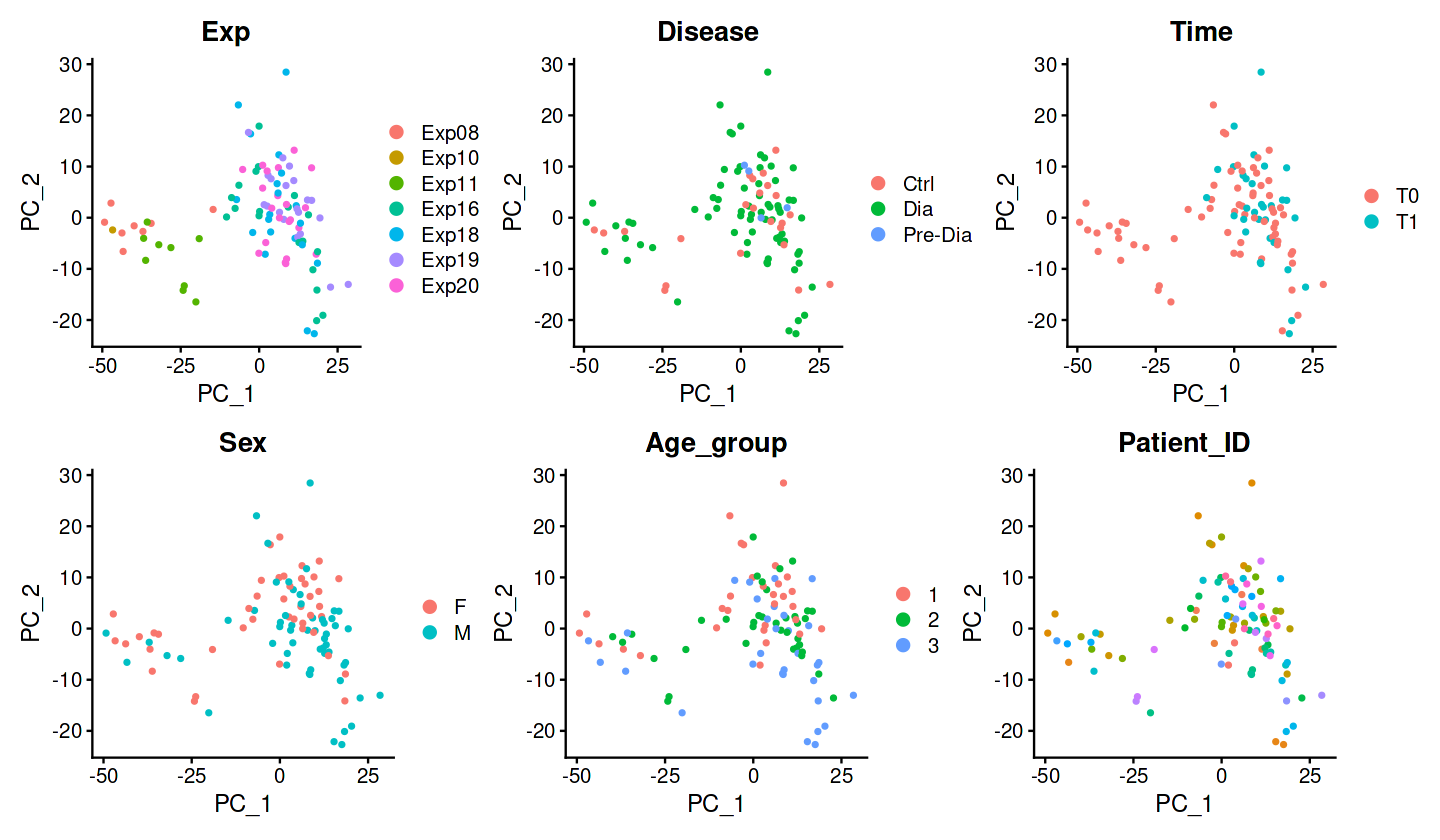

In [88]:
options(repr.plot.width = 12, repr.plot.height = 7)
(DimPlot(cd8_samples2, group.by = "Exp") + DimPlot(cd8_samples2, group.by = "Disease") + DimPlot(cd8_samples2, group.by = "Time")) / 
(DimPlot(cd8_samples2, group.by = "Sex") + DimPlot(cd8_samples2, group.by = "Age_group") + (DimPlot(cd8_samples2, group.by = "Patient_ID") + NoLegend()))

In [89]:
saveRDS(new_dia_experiment, "data/processed/cd8_full.rds")

# Add metadata

In [90]:
md_dia  <- read_xlsx("data/dia_metadata.xlsx")

In [91]:
md_dia

id_pat patient rc         dat_nar    matched_dataset_manual
1  101    101     1812230552 2018-12-23 NA                    
2  102    102     1711110951 2017-11-11 NA                    
3  103    103     1304191240 2013-04-19 yes                   
4  104    104     0408165087 2004-08-16 NA                    
5  105    105     1706101309 2017-06-10 NA                    
6  106    106     1959271281 2019-09-27 NA                    
7  107    107     1610250708 2016-10-25 NA                    
8  108    108     1355270697 2013-05-27 yes                   
9  109    109     1506260129 2015-06-26 NA                    
10 110    110     1110211542 2011-10-21 NA                    
11 111    111     1053144928 2010-03-14 NA                    
12 112    112     1052214955 2010-02-21 NA                    
13 113    113     1308130153 2013-08-13 NA                    
14 114    114     1555051839 2015-05-05 NA                    
15 115    115     1205110896 2012-05-11 yes                   
16 116    116     1803170534 2018-03-17 NA                    
17 117    117     1651170972 2016-01-17 NA                    
18 118    118     1006214715 2010-06-21 NA                    
19 119    119     1660071611 2016-10-07 NA                    
20 120    120     1203604039 2012-03-10 NA                    
21 121    121     0704242715 2007-04-24 NA                    
22 122    122     0507194468 2005-07-19 NA                    
23 123    123     0412304453 2004-12-30 NA                    
24 124    124     1201161731 2012-01-16 NA                    
25 125    125     0507144693 2005-07-14 NA                    
26 126    126     0756094636 2007-06-09 yes                   
27 127    127     0561282095 2005-11-28 NA                    
28 128    128     0405268908 2004-05-26 NA                    
29 129    129     0510252094 2005-10-25 NA                    
30 130    130     0858067848 2008-08-06 NA                    
⋮  ⋮      ⋮       ⋮          ⋮          ⋮                     
48 101    101     1812230552 2018-12-23 NA                    
49 102    102     1711110951 2017-11-11 NA                    
50 103    103     1304191240 2013-04-19 yes                   
51 104    104     0408165087 2004-08-16 NA                    
52 105    105     1706101309 2017-06-10 NA                    
53 106    106     1959271281 2019-09-27 NA                    
54 107    107     1610250708 2016-10-25 NA                    
55 108    108     1355270697 2013-05-27 yes                   
56 109    109     1506260129 2015-06-26 NA                    
57 110    110     1110211542 2011-10-21 NA                    
58 111    111     1053144928 2010-03-14 NA                    
59 112    112     1052214955 2010-02-21 NA                    
60 113    113     1308130153 2013-08-13 NA                    
61 114    114     1555051839 2015-05-05 NA                    
62 115    115     1205110896 2012-05-11 yes                   
63 116    116     1803170534 2018-03-17 NA                    
64 117    117     1651170972 2016-01-17 NA                    
65 118    118     1006214715 2010-06-21 NA                    
66 119    119     1660071611 2016-10-07 NA                    
67 120    120     1203604039 2012-03-10 NA                    
68 121    121     0704242715 2007-04-24 NA                    
69 122    122     0507194468 2005-07-19 NA                    
70 123    123     0412304453 2004-12-30 NA                    
71 124    124     1201161731 2012-01-16 NA                    
72 125    125     0507144693 2005-07-14 NA                    
73 126    126     0756094636 2007-06-09 yes                   
74 127    127     0561282095 2005-11-28 NA                    
75 128    128     0405268908 2004-05-26 NA                    
76 129    129     0510252094 2005-10-25 NA                    
77 130    130     0858067848 2008-08-06 NA                    
   matched_group_manual matched_dataset_propensity matched_group_propensity
1  NA                

In [92]:
md_seurat  <- new_dia_experiment@meta.data

In [93]:
md_seurat$Patient_Time  <- paste(md_seurat$Patient_ID, md_seurat$Time)

In [94]:
md_joined  <- left_join(md_seurat, md_dia)

Joining with `by = join_by(Patient_Time)`


In [95]:
new_dia_experiment@meta.data  <- md_joined
rownames(new_dia_experiment@meta.data)  <- colnames(new_dia_experiment)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



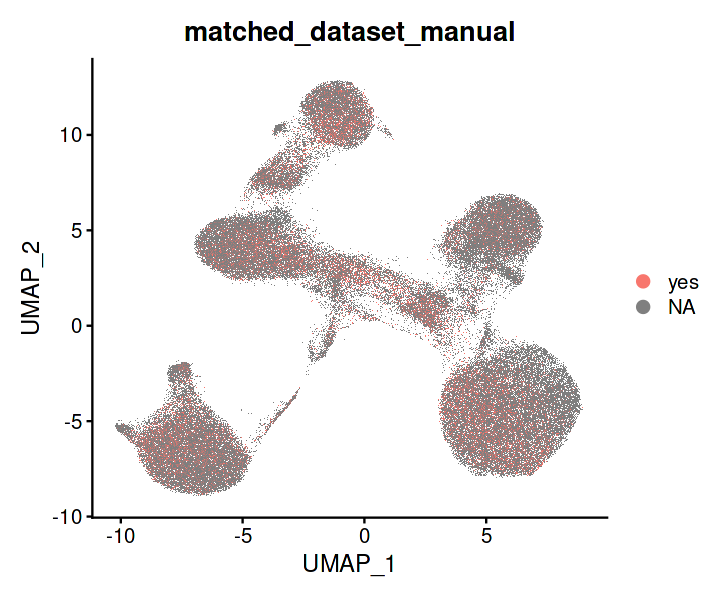

In [102]:
options(repr.plot.width = 6, repr.plot.height = 5)

DimPlot(new_dia_experiment, group.by = "matched_dataset_manual", raster = T)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



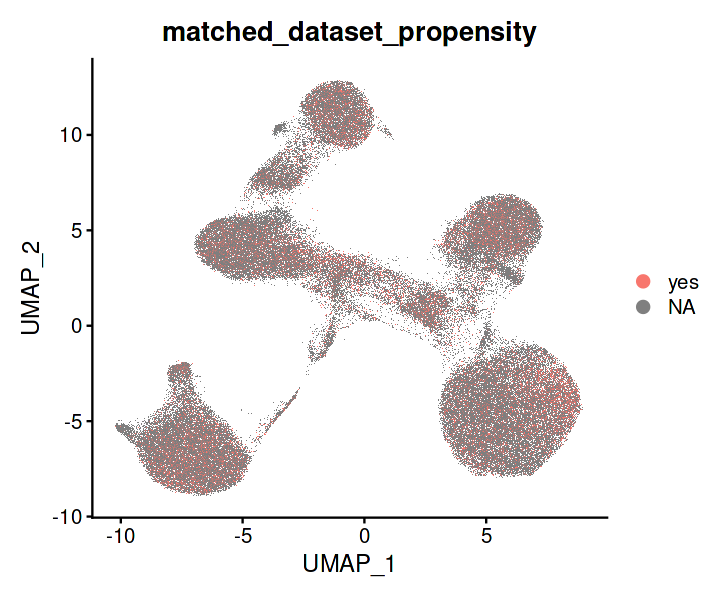

In [101]:
DimPlot(new_dia_experiment, group.by = "matched_dataset_propensity", raster = T)

# Analysis CD8 Level 1

In [103]:
new_dia_cd8  <- new_dia_experiment

In [104]:
new_dia_cd8 <- FindNeighbors(new_dia_cd8, dims = 1:12)

Computing nearest neighbor graph

Computing SNN



In [106]:
new_dia_cd8 <- FindClusters(new_dia_cd8, resolution = 0.6)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 105591
Number of edges: 2903750

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8990
Number of communities: 16
Elapsed time: 61 seconds


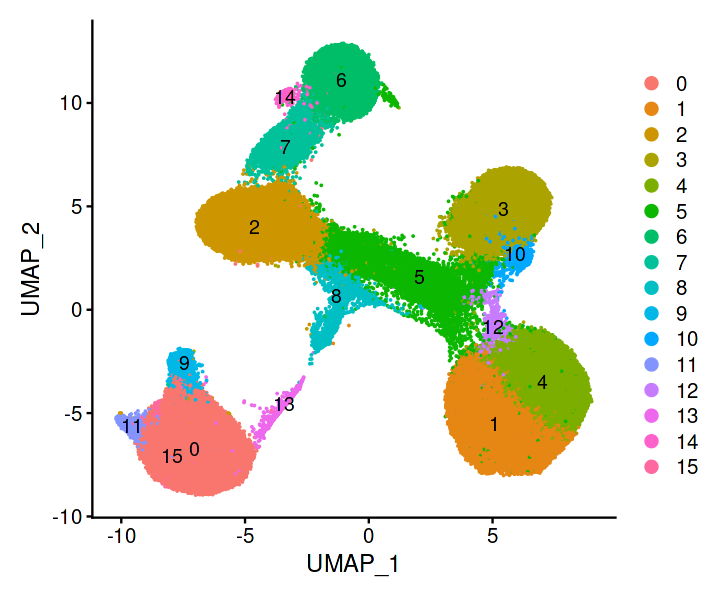

In [108]:
DimPlot(new_dia_cd8, label = T, raster = F)

In [109]:
new_dia_cd8@meta.data  <- new_dia_cd8@meta.data  %>% 
mutate(annotations_l1 = recode_factor(seurat_clusters, 
                                     "0" = "NK cells",
                                     "9" = "NK cells",
                                     "11" = "NK cells",
                                     "13" = "NK cells",
                                     "15" = "NK cells",
                                     "1" = "CD8 T cells",
                                     "2" = "CD8 T cells",
                                     "3" = "CD8 T cells",
                                     "5" = "CD8 T cells",
                                     "4" = "CD8 T cells",
                                     "6" = "Unconventional T cells",
                                     "7" = "Unconventional T cells",
                                     "8" = "CD8 T cells",
                                     "10" = "CD8 T cells",
                                     "12" = "CD8 T cells",
                                     "14" = "Unconventional T cells"
                                     ))

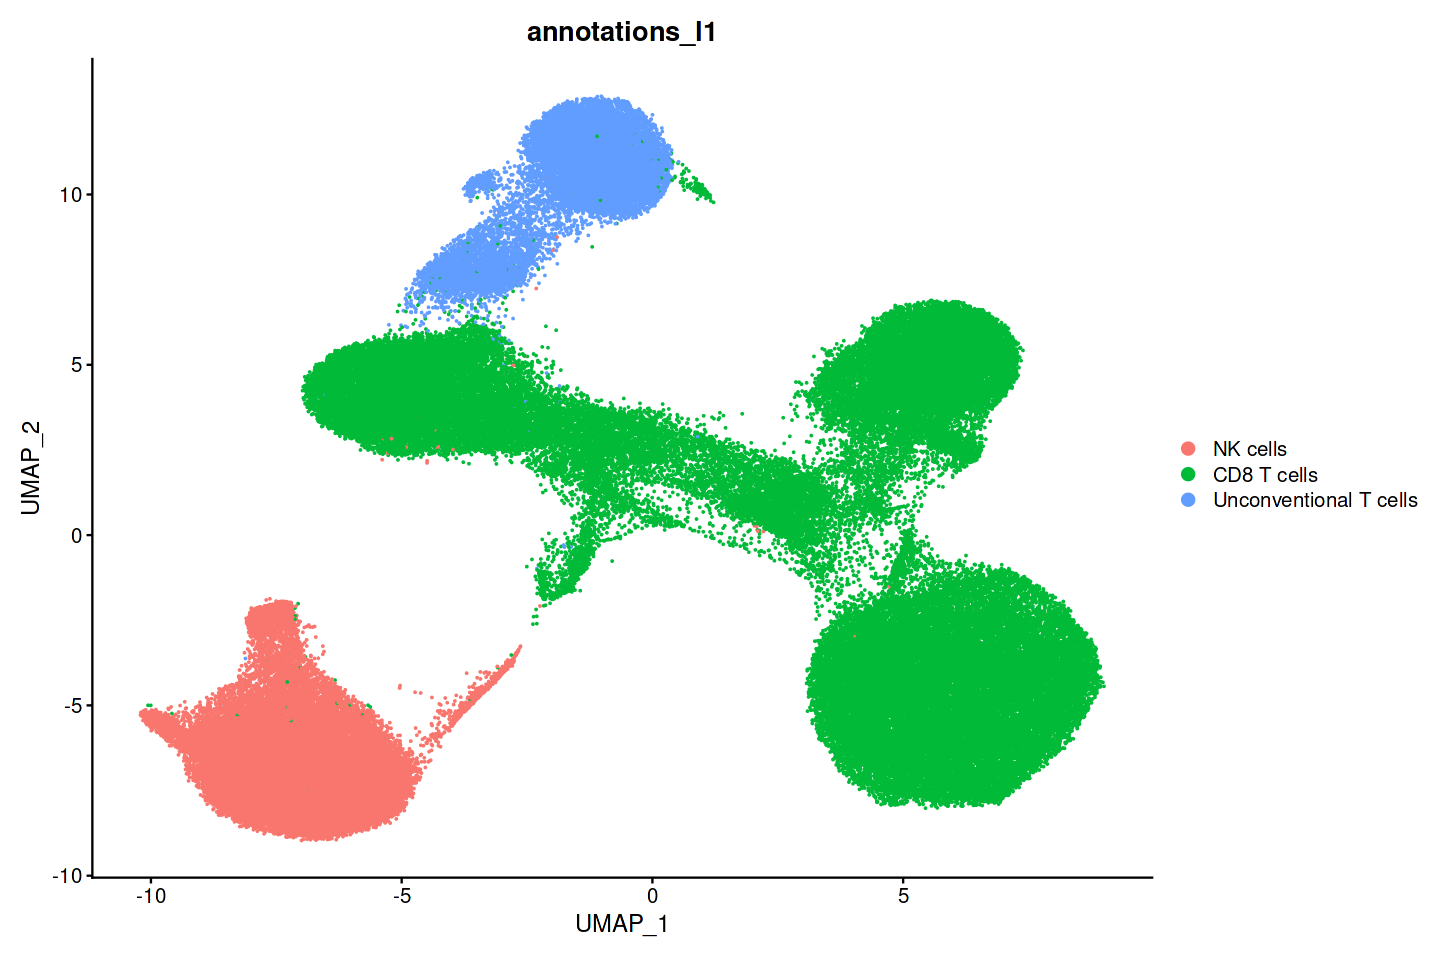

In [110]:
options(repr.plot.width = 12, repr.plot.height = 8)

DimPlot(new_dia_cd8, group.by = "annotations_l1", raster = F)

In [111]:
saveRDS(new_dia_cd8, "data/processed/cd8_full.rds")

# Analysis CD8 Level 2

In [113]:
merged.list  <- SplitObject(subset(new_dia_cd8, annotations_l1 == "CD8 T cells"), split.by = "Experiment_ID")

In [ ]:

new_dia_experiment2 <- Run.STACAS(merged.list, dims = 1:12)

new_dia_experiment2 <- RunUMAP(new_dia_experiment2, dims = 1:12) 

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in

In [ ]:
cd8_subcluster  <- new_dia_experiment2

In [ ]:
cd8_subcluster <- FindNeighbors(cd8_subcluster, reduction = "pca", dims = 1:12)

In [ ]:
cd8_subcluster <- FindClusters(cd8_subcluster, resolution = 0.6)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(cd8_subcluster, label = T, group.by = "annotations_l2")

In [461]:
Idents(cd8_subcluster)  <- cd8_subcluster$annotations_l2

In [462]:
mrk_cd8_subcluster  <- FindAllMarkers(cd8_subcluster)

Calculating cluster Naive

Calculating cluster Temra

Calculating cluster Tem

Calculating cluster Tcm 2

Calculating cluster Tcm 1

Calculating cluster Proliferating

Calculating cluster Tem ISAGhi

Calculating cluster Naive ISAGhi



In [463]:
write.csv(mrk_cd8_subcluster, "markers_cd8_level2_annotations_l2.csv")

Warning message:
“Could not find PTPRC-RA in the default search locations, found in PTPRC assay instead”
Warning message:
“Could not find PTPRC-RO in the default search locations, found in PTPRC assay instead”


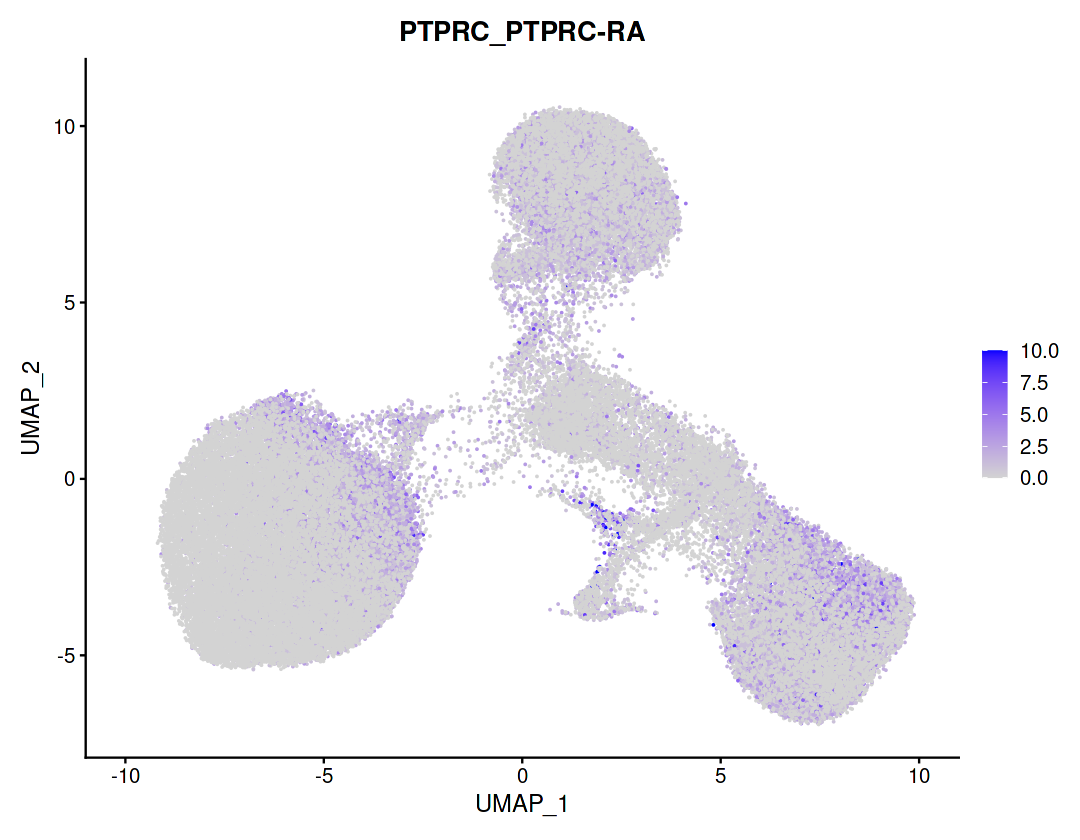

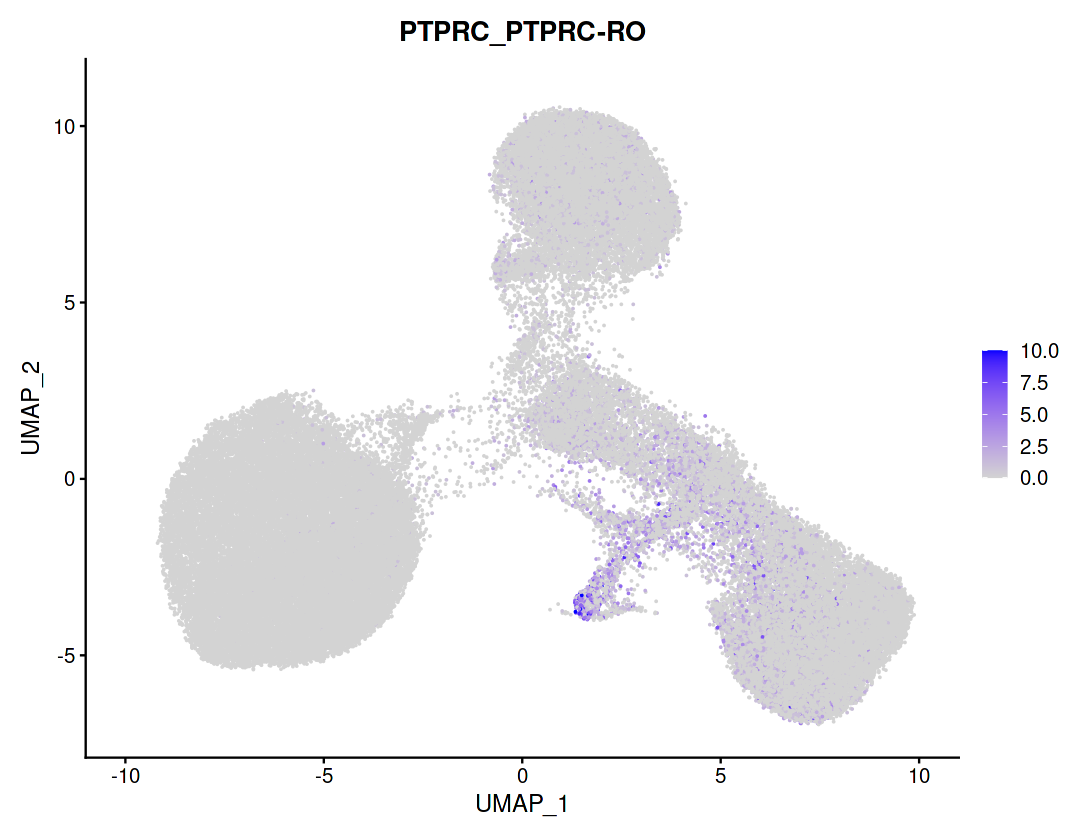

In [455]:
options(repr.plot.width = 9, repr.plot.height = 7)
FeaturePlot(cd8_subcluster, features = "PTPRC-RA", min.cutoff = 0, max.cutoff = 10)
FeaturePlot(cd8_subcluster, features = "PTPRC-RO", min.cutoff = 0, max.cutoff = 10)

In [198]:
cd8_subcluster@meta.data  <- cd8_subcluster@meta.data  %>% 
mutate(annotations_l2 = recode_factor(seurat_clusters, 
                                      "0" = "Naive",
                                     "1" = "Temra",
                                     "2" = "Tem",
                                     "3" = "Naive",
                                     "4" = "Tcm 2",
                                     "5" = "Tcm 1",
                                     "6" = "Proliferating",
                                     "7" = "Tem ISAGhi",
                                     "8" = "Naive ISAGhi"
                                     ))

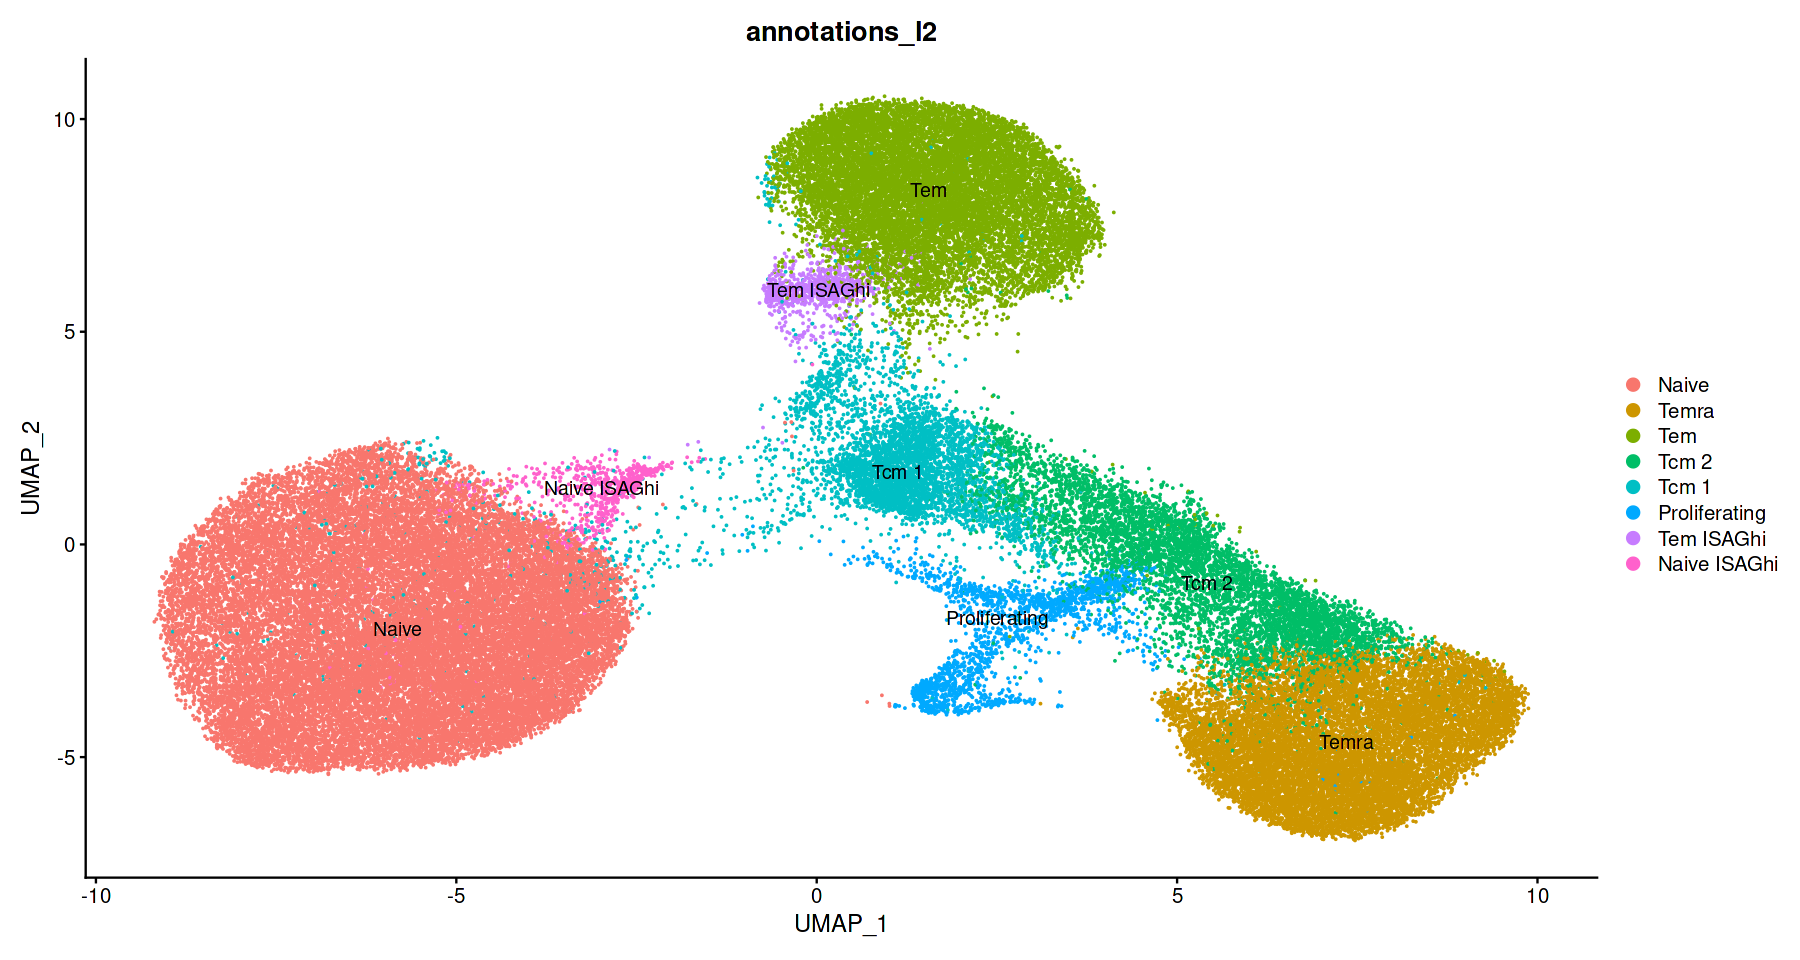

In [620]:
DimPlot(cd8_subcluster, label = T, group.by = "annotations_l2")